In [1]:
from event_pipeline import Event
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import obspy.signal.trigger as trigger

import matplotlib.dates as dates
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def get_event(event_id, day_number, df, hanning=True):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
              , hanning=hanning
             )
    return e

def get_times(event):
    trace = event.stream[event.first_hydrophone_id]
    times = trace.times()
    times_len = times.shape[0]
    return np.arange(0, times_len, 1)

def plot_50hz_highpass(event, ax):
    trace = event.stream[event.first_hydrophone_id].copy()
    times = get_times(event=event)
    tr = trace.copy().filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)


def plot_aic_pick(event, ax):
    times = get_times(event=event)
    # its 0.4 because its 2/5 because its 0.2s before and 0.3 after
    aic_time = times[int(0.4*times.shape[0])]
    ax.vlines(x=aic_time, ymin=-100, ymax=100, color='cyan'
              ,linewidth=3, label='AIC pick', zorder=0)

def plot_aic(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)

def plot_aic_diff(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')

In [3]:
df141 = import_catalog(file='141precision.csv')
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime', 'origin_time']

df141 = df141[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)


# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)


Text(0, 0.5, 'diff(AIC)')

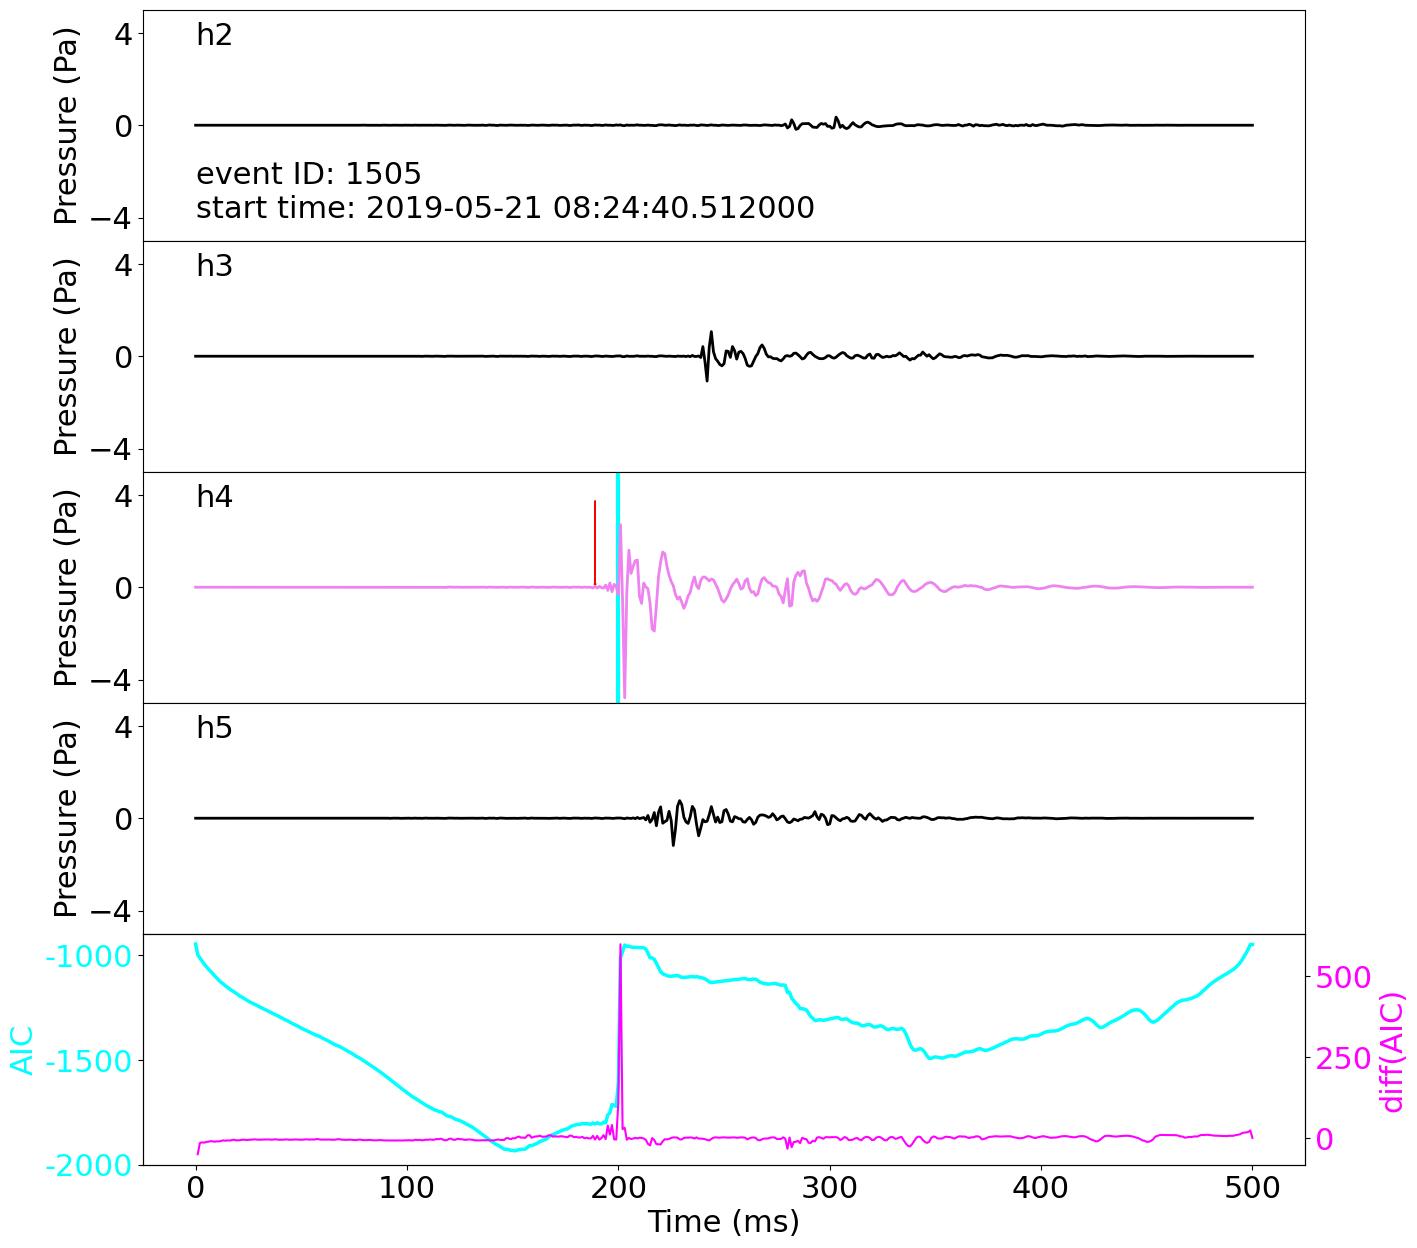

In [4]:
# plot_event(event_id=1505, day_number=141, df=df141)
event_id = 1505
ptime = 0.189
e = get_event(event_id=event_id, day_number=141, df=df141)


fig, ax = plt.subplots(5, 1, figsize=(15, 15), sharex=True,)
plt.subplots_adjust(hspace=0)

starttime = (e.stream[0].stats.starttime).datetime
ax[0].text(s=f'event ID: {event_id}\nstart time: {starttime}', x=0, y=-4)

for n, tr in enumerate(e.stream[2:]):
    # don't plot the first arrival twice
    if n == 2:
        pass
    else:
        times = tr.times()
        times = np.arange(0, times.shape[0], 1)
        tr = tr.copy().filter(type='highpass', freq=50)
        ax[n].plot(times, tr.data, color='black', label='50Hz highpass'
                ,linewidth=2)


plot_aic_pick(event=e, ax=ax[2])

plot_50hz_highpass(event=e, ax=ax[2])

ax[2].arrow(x=ptime*1e3, y=3.75, dx=0, dy=-3.6, color='red'
            , head_width=1, head_length=0.05, label='p-arrival')
for n in [0, 1, 2, 3]:
    ax[n].set_ylim(-5, 5)
    ax[n].set_yticks([-4, 0, 4])
    ax[n].set_ylabel('Pressure (Pa)')
    ax[n].text(s=f'h{n+2}', x=0, y=3.5)


plot_aic(event=e, ax=ax[-1])
ax2 = ax[-1].twinx()
plot_aic_diff(event=e, ax=ax2)

ax[-1].set_xlabel('Time (ms)')
ax[-1].set_yticks([-2000, -1500, -1000])
ax[-1].set_yticklabels([-2000, -1500, -1000], color='cyan')
ax[-1].set_ylabel('AIC', color='cyan')

ax2.set_yticks([0, 250, 500])
ax2.set_yticklabels([0, 250, 500], color='magenta')
ax2.set_ylabel('diff(AIC)', color='magenta')


# fig.tight_layout()

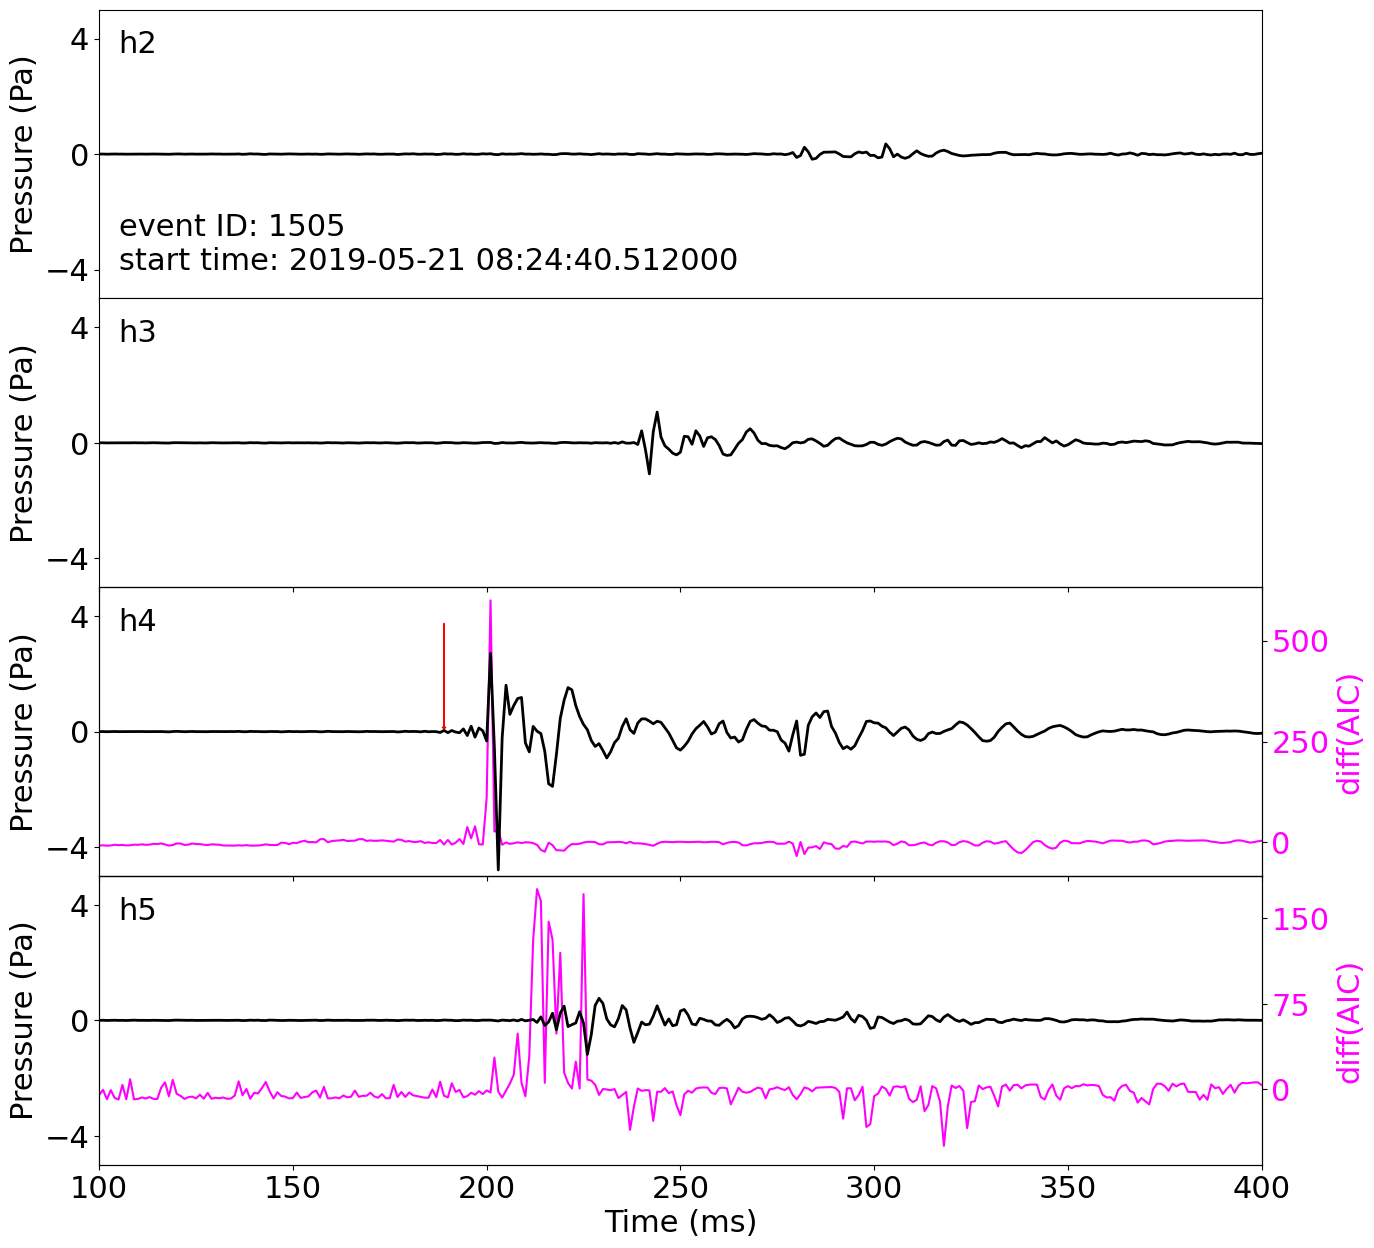

In [5]:
# plot_event(event_id=1505, day_number=141, df=df141)
event_id = 1505
ptime = 0.189
e = get_event(event_id=event_id, day_number=141, df=df141)

fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True,)
plt.subplots_adjust(hspace=0)

starttime = (e.stream[0].stats.starttime).datetime
# ax[0].text(s=f'event ID: {event_id}\nstart time: {starttime}', x=0, y=-4)
ax[0].text(s=f'event ID: {event_id}\nstart time: {starttime}', x=105, y=-4)

ax[2].arrow(x=ptime*1e3, y=3.75, dx=0, dy=-3.6, color='red'
            , head_width=1, head_length=0.05, label='p-arrival')
for n in [0, 1, 2, 3]:
    ax[n].set_ylim(-5, 5)
    ax[n].set_yticks([-4, 0, 4])
    ax[n].set_ylabel('Pressure (Pa)')
    # ax[n].text(s=f'h{n+2}', x=0, y=3.5)
    ax[n].text(s=f'h{n+2}', x=105, y=3.5)


# plot_aic(event=e, ax=ax[-1])
plot_aic(event=e, ax=ax[2])
# ax2 = ax[-1].twinx()
ax2 = ax[2].twinx()
plot_aic_diff(event=e, ax=ax2)

# ax[-1].set_xlabel('Time (ms)')
# ax[-1].set_yticks([-2000, -1500, -1000])
# ax[-1].set_yticklabels([-2000, -1500, -1000], color='cyan')
# ax[-1].set_ylabel('AIC', color='cyan')

ax2.set_yticks([0, 250, 500])
ax2.set_yticklabels([0, 250, 500], color='magenta')
ax2.set_ylabel('diff(AIC)', color='magenta')

tr = e.stream[-1].copy()
tr.filter(type='highpass', freq=50)
aics = trigger.aic_simple(tr.data)

# fig, ax = plt.subplots(figsize=(15, 5))
ax[-1].plot(aics)
ax3 = ax[-1].twinx()
ax3.plot(np.diff(aics, n=1), color='magenta')
ax3.set_yticks([0, 75, 150])
ax3.set_yticklabels([0, 75, 150], color='magenta')
ax3.set_ylabel('diff(AIC)', color='magenta')
# fig.tight_layout()

for n, tr in enumerate(e.stream[2:]):
    # don't plot the first arrival twice
    # if n == 2:
    #     pass
    # else:
    times = tr.times()
    times = np.arange(0, times.shape[0], 1)
    tr = tr.copy().filter(type='highpass', freq=50)
    ax[n].plot(times, tr.data, color='black', label='50Hz highpass'
            ,linewidth=2)

ax[2].set_zorder(ax2.get_zorder()+1)
ax[2].patch.set_visible(False)

ax[-1].set_zorder(ax3.get_zorder()+1)
ax[-1].patch.set_visible(False)

ax[-1].set_xlabel('Time (ms)')
ax[-1].set_xlim(100, 400)
fig.savefig('fig3.pdf', bbox_inches='tight')

In [6]:
# e.stream

In [7]:
# calculates aic score


# # finds minimum and returns index for aic scores
# diffs = [np.diff(aic, n=1) for aic in aics]
# maxes = [np.argmax(diff) for diff in diffs]

In [8]:
# tr = e.stream[-1].copy()
# tr.filter(type='highpass', freq=50)
# aics = trigger.aic_simple(tr.data)

# fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(aics)
# ax2 = ax.twinx()
# ax2.plot(np.diff(aics, n=1), color='red')

In [9]:
# tr.plot()